
### Created on Fri Jun 22th 2020

### @author: Maximilian Forstenhaeusler

# AFM - Contact Mode Verification and time step comparison using the afmsim library

### Description 
This notebook is used to verify the generlized contact mode function, contact_mode_gen, from the afmsim linrary amd investigate the impact of the timestep to the iteration. 

### Call libraries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time as tm
import pandas as pd
from matplotlib import cm
from afmsim import contact_mode_gen, contact_mode, differential_constants
from numba import jit
from joblib import dump

__________________________________________________________________________________________________________________
### Input parameteres
#### Cantilever and tip parameters

In [2]:
vb = 1000e-9  # velocity of approaching sample
zb = 3e-9  # initial position of cantilever
Q1 = 100  # Quality Factor
k_m1 = 0.1  # equilibrium cantilever mass
fo1 = 10e3  # natural frequency
period1 = 1.0 / fo1  # fundamental period
R = 20e-9  # radius tip
nu = 0.5  # poissons ratio of material

#### Molecular Interaction Forces - Constants

In [3]:
vdw = 2  # vdw constant

#### Simulation Time

In [4]:
start = 0  # defines start of the simulation
landingtime = zb / vb
final_time = 0.1  # indentation time
stop = landingtime + final_time  # defines end of the simulation
timestep = [period1 / 1.0e2, period1 / 1.0e3, period1 / 1.0e4, period1 / 1.0e5]
printstep = period1 / 10  # printstep of Force distance curve

time = [np.arange(start, stop, timestep[0]), np.arange(start, stop, timestep[1]), np.arange(start, stop, timestep[2]), np.arange(start, stop, timestep[3])] # time array 


#### Viscelastic Model Parameter 

In [5]:
arms = [3, 5]
Jg = 2.0e-10  # Glassy compliance
J_3 = np.zeros(arms[0])  # compliance array - 3 arm
tau_3 = np.zeros(arms[0])  # characteristic time array - 3 arm
J_5 = np.zeros(arms[1])  # compliance array - 5 arm
tau_5 = np.zeros(arms[1])  # characteristic time array - 5 arm

J_3[0], tau_3[0] = 5.0e-9, 0.5e-4
J_3[1], tau_3[1] = 7.0e-9, 0.5e-3
J_3[2], tau_3[2] = 1.0e-10, 0.5e-2

J_5[0], tau_5[0] = 5.0e-9, 0.5e-4
J_5[1], tau_5[1] = 7.0e-9, 0.5e-3
J_5[2], tau_5[2] = 1.0e-10, 0.5e-2
J_5[3], tau_5[3] = 3.0e-6, 0.5e-1
J_5[4], tau_5[4] = 4.0e-6, 0.5e-0

__________________________________________________________________________________________________________________

## AFM - Contact Mode Simulation (SFS)

#### Calculation of differential constants used for tip-sample force calculation in AFM simulation

In [6]:
u_3, q_3 = differential_constants('Gen. Kelvin-Voigt', Jg, J_3, tau_3)  # 3 Arm
u_5, q_5 = differential_constants('Gen. Kelvin-Voigt', Jg, J_5, tau_5)  # 5 Arm


### Simulation - Verification of Generalized Contact Mode function

In [7]:
AFM_jit = jit()(contact_mode)  # calls AFM simul function and initializes numba procedure to increase iter. speed
AFM_gen_jit = jit()(contact_mode_gen)

#- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
print('Timestep 1:', timestep[2])
t0 = tm.time()
Fts_3_0, tip_3_0, base_3_0 = AFM_jit(time[2], timestep[2], zb, vb, u_3, q_3, k_m1, fo1, Q1, vdw, R, nu)
t1 = tm.time()
print('Total simulation time: %2.3f' % (t1 - t0))

t2 = tm.time()
Fts_gen_3_0, tip_gen_3_0, base_gen_3_0 = AFM_gen_jit(time[2], timestep[2], zb, vb, u_3, q_3, k_m1, fo1, Q1, vdw, R)
t3 = tm.time()
print('Total simulation time: %2.3f' % (t3 - t2))

t4 = tm.time()
Fts_5_0, tip_5_0, base_5_0 = AFM_jit(time[2], timestep[2], zb, vb, u_5, q_5, k_m1, fo1, Q1, vdw, R, nu)
t5 = tm.time()
print('Total simulation time: %2.3f' % (t5 - t4))

t6 = tm.time()
Fts_gen_5_0, tip_gen_5_0, base_gen_5_0 = AFM_gen_jit(time[2], timestep[2], zb, vb, u_5, q_5, k_m1, fo1, Q1, vdw, R, nu)
t7 = tm.time()
print('Total simulation time: %2.3f' % (t7 - t6))

Timestep 1: 1e-08
Generalized 3 Arm Maxwell/Kelvin-Voigt
Total simulation time: 4.641
Total simulation time: 9.622
Generalized 5 Arm Maxwell/Kelvin-Voigt
Total simulation time: 2.195
Total simulation time: 11.283


__________________________________________________________________________________________________________________
###  Force - Distance Graph

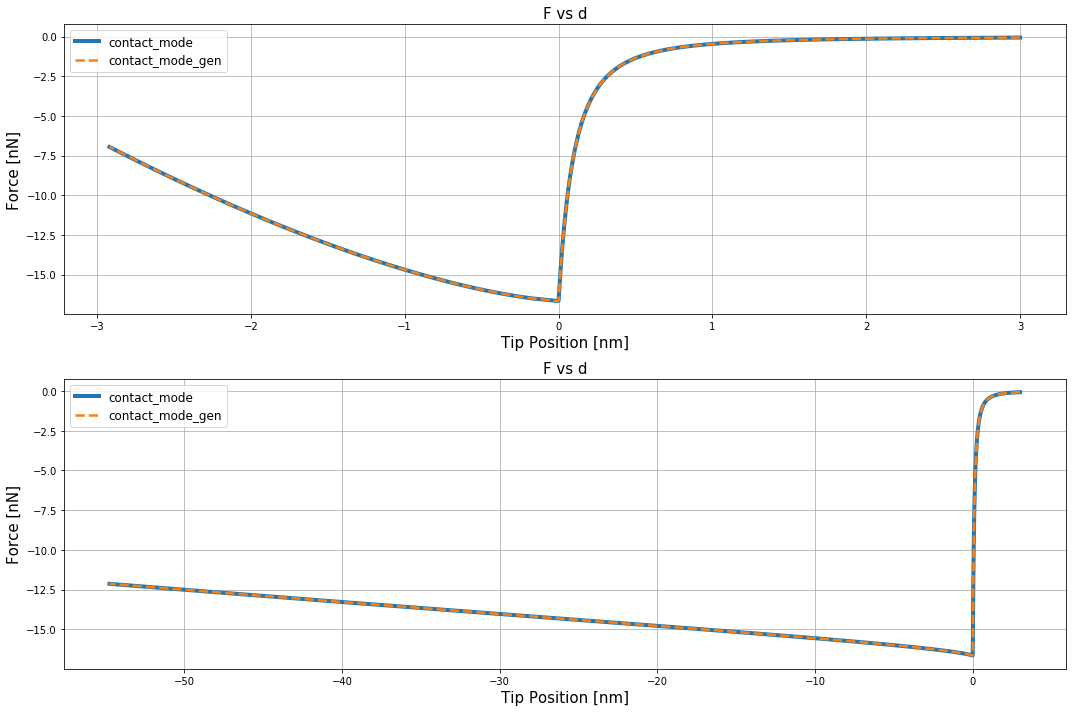

In [8]:
cmap = cm.coolwarm
colors = [cmap(0.01), cmap(0.2), cmap(0.9)]

fig, ax = plt.subplots(2, 1, figsize=(15, 10), tight_layout=True)

ax[0].set_title('F vs d', fontsize=15)
ax[0].plot(tip_3_0[::int(1e3)]*1e9, Fts_3_0[::int(1e3)]*1e9, '-', lw=4, label='contact_mode')
ax[0].plot(tip_gen_3_0[::int(1e3)]*1e9, Fts_gen_3_0[::int(1e3)]*1e9, '--', lw=2.5,  label='contact_mode_gen')
ax[0].set_xlabel('Tip Position [nm]', fontsize=15)
ax[0].set_ylabel('Force [nN]', fontsize=15)
ax[0].grid()
ax[0].legend(fontsize=12)

ax[1].set_title('F vs d', fontsize=15)
ax[1].plot(tip_5_0[::int(1e3)]*1e9, Fts_5_0[::int(1e3)]*1e9, '-', lw=4, label='contact_mode')
ax[1].plot(tip_gen_5_0[::int(1e3)]*1e9, Fts_gen_5_0[::int(1e3)]*1e9, '--', lw=2.5,  label='contact_mode_gen')
ax[1].set_xlabel('Tip Position [nm]', fontsize=15)
ax[1].set_ylabel('Force [nN]', fontsize=15)
ax[1].grid()
ax[1].legend(fontsize=12)

plt.show()

### Impact of Time Step 

In [9]:
data = {}
data['contact_mode_gen'] = {}
data['contact_mode_gen']['3-Arm'] = {}
data['contact_mode_gen']['5-Arm'] = {}
data['contact_mode_gen']['3-Arm']['Time Step'] = {}
data['contact_mode_gen']['5-Arm']['Time Step'] = {}

for i in range(len(timestep)):
    t0 = tm.time()
    Fts_gen, tip_gen, base_gen = AFM_gen_jit(time[i], timestep[i], zb, vb, u_3, q_3, k_m1, fo1, Q1, vdw, R)
    t1 = tm.time()
    print(' - - - 3 Arm - %s: - - - ' %timestep[i])
    print('Total simulation time: %2.3f' % (t1 - t0))
    data['contact_mode_gen']['3-Arm']['Time Step']['%s' %timestep[i]] = {'time': time[i],
                                                                        'Fts': Fts_gen,
                                                                        'Tip': tip_gen,
                                                                        'Base': base_gen}
    t2 = tm.time()
    Fts_gen, tip_gen, base_gen = AFM_gen_jit(time[i], timestep[i], zb, vb, u_5, q_5, k_m1, fo1, Q1, vdw, R)
    t3 = tm.time()
    print(' - - - 5 Arm - %s: - - - ' %timestep[i])
    print('Total simulation time: %2.3f' % (t3 - t2))
    data['contact_mode_gen']['5-Arm']['Time Step']['%s' %timestep[i]] = {'time': time[i],
                                                                        'Fts': Fts_gen,
                                                                        'Tip': tip_gen,
                                                                        'Base': base_gen}
    print('\n')

 - - - 3 Arm - 1e-06: - - - 
Total simulation time: 0.008
 - - - 5 Arm - 1e-06: - - - 
Total simulation time: 0.014


 - - - 3 Arm - 1.0000000000000001e-07: - - - 
Total simulation time: 0.816
 - - - 5 Arm - 1.0000000000000001e-07: - - - 
Total simulation time: 0.864


 - - - 3 Arm - 1e-08: - - - 
Total simulation time: 7.981
 - - - 5 Arm - 1e-08: - - - 
Total simulation time: 8.094


 - - - 3 Arm - 1e-09: - - - 
Total simulation time: 95.096
 - - - 5 Arm - 1e-09: - - - 
Total simulation time: 110.286




In [10]:
key1 = data['contact_mode_gen']['3-Arm']['Time Step'].keys()
key2 = []
for key in key1:
    key2.append(data['contact_mode_gen']['3-Arm']['Time Step'][key].keys())
key1 = pd.DataFrame(key1)
key2 = pd.DataFrame(key2[0])

In [11]:
time_3 = []
Fts_3 = [] 
tip_3 = []
base_3 = []

time_5 = []
Fts_5 = [] 
tip_5 = []
base_5 = []

for i in range(len(key1)):
    
    for j in range(len(key2)):
        if j == 0:
            time_3.append(data['contact_mode_gen']['3-Arm']['Time Step'][key1.iloc[i, 0]][key2.iloc[j, 0]])
            time_3.append(data['contact_mode_gen']['5-Arm']['Time Step'][key1.iloc[i, 0]][key2.iloc[j, 0]])
        if j == 1:
            Fts_3.append(data['contact_mode_gen']['3-Arm']['Time Step'][key1.iloc[i, 0]][key2.iloc[j, 0]])
            Fts_5.append(data['contact_mode_gen']['5-Arm']['Time Step'][key1.iloc[i, 0]][key2.iloc[j, 0]])
        if j == 2:
            tip_3.append(data['contact_mode_gen']['3-Arm']['Time Step'][key1.iloc[i, 0]][key2.iloc[j, 0]])
            tip_5.append(data['contact_mode_gen']['5-Arm']['Time Step'][key1.iloc[i, 0]][key2.iloc[j, 0]])
        else:
            base_3.append(data['contact_mode_gen']['3-Arm']['Time Step'][key1.iloc[i, 0]][key2.iloc[j, 0]])
            base_5.append(data['contact_mode_gen']['5-Arm']['Time Step'][key1.iloc[i, 0]][key2.iloc[j, 0]])

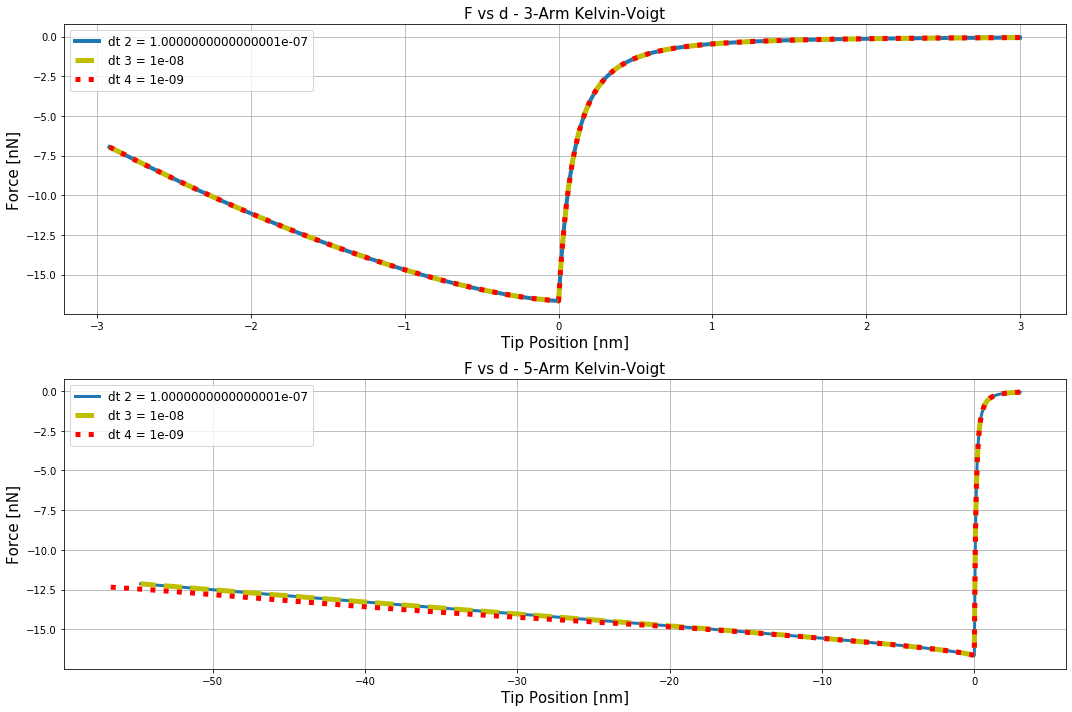

In [12]:
cmap = cm.coolwarm
colors = [cmap(0.01), cmap(0.2), cmap(0.9)]

fig, ax = plt.subplots(2, 1, figsize=(15, 10), tight_layout=True)

ax[0].set_title('F vs d - 3-Arm Kelvin-Voigt', fontsize=15)
ax[0].plot(tip_3[1][::int(1e2)]*1e9, Fts_3[1][::int(1e2)]*1e9, '-', lw=4,  label='dt 2 = %s' %timestep[1])
ax[0].plot(tip_3[2][::int(1e3)]*1e9, Fts_3[2][::int(1e3)]*1e9, '--', lw=5, c='y', label='dt 3 = %s' %timestep[2])
ax[0].plot(tip_3[3][::int(1e4)]*1e9, Fts_3[3][::int(1e4)]*1e9, ':', lw=5, c='r', label='dt 4 = %s' %timestep[3])
ax[0].set_xlabel('Tip Position [nm]', fontsize=15)
ax[0].set_ylabel('Force [nN]', fontsize=15)
ax[0].grid()
ax[0].legend(fontsize=12)

ax[1].set_title('F vs d - 5-Arm Kelvin-Voigt', fontsize=15)
ax[1].plot(tip_5[1][::int(1e2)]*1e9, Fts_5[1][::int(1e2)]*1e9, '-', lw=3,  label='dt 2 = %s' %timestep[1])
ax[1].plot(tip_5[2][::int(1e3)]*1e9, Fts_5[2][::int(1e3)]*1e9, '--', c='y',lw=5, label='dt 3 = %s' %timestep[2])
ax[1].plot(tip_5[3][::int(1e4)]*1e9, Fts_5[3][::int(1e4)]*1e9, ':', c='r', lw=5, label='dt 4 = %s' %timestep[3])
ax[1].set_xlabel('Tip Position [nm]', fontsize=15)
ax[1].set_ylabel('Force [nN]', fontsize=15)
ax[1].grid()
ax[1].legend(fontsize=12)

plt.show()

The top graphs are exmamples of an acceptable time step for the simulation. If the time step is too large, the stability of the numerical methods applied become critical and falsifies the results. See the example below.

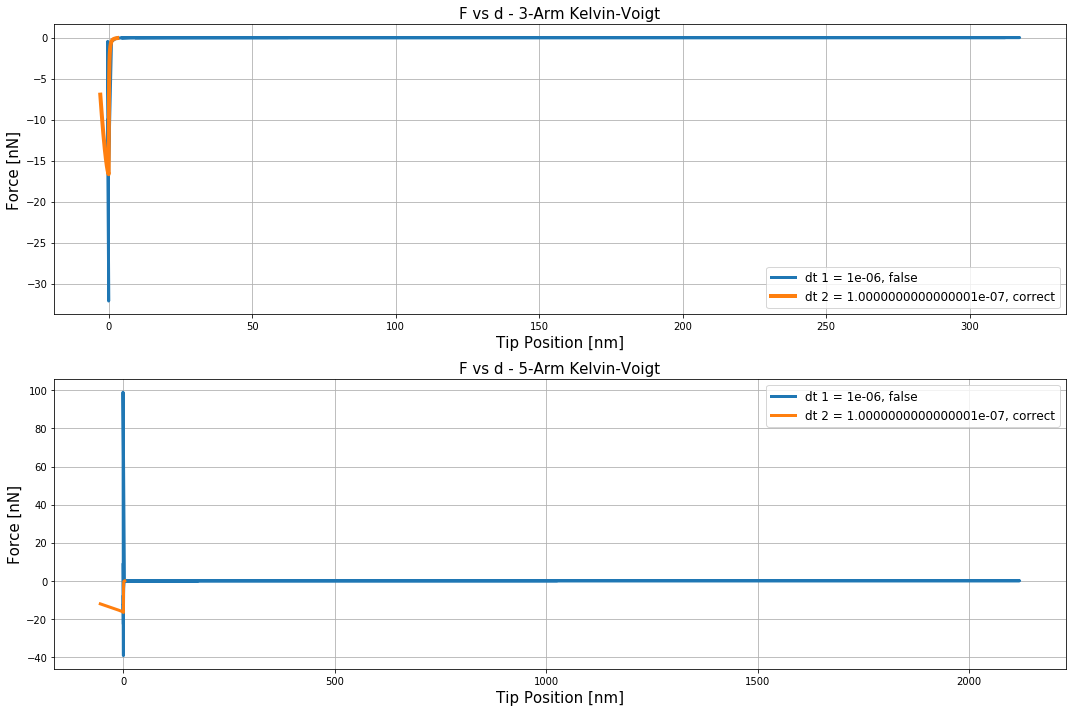

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10), tight_layout=True)

ax[0].set_title('F vs d - 3-Arm Kelvin-Voigt', fontsize=15)
ax[0].plot(tip_3[0]*1e9, Fts_3[0]*1e9, '-', lw=3, label='dt 1 = %s, false' %timestep[0])
ax[0].plot(tip_3[1][::int(1e2)]*1e9, Fts_3[1][::int(1e2)]*1e9, '-', lw=4,  label='dt 2 = %s, correct' %timestep[1])
ax[0].set_xlabel('Tip Position [nm]', fontsize=15)
ax[0].set_ylabel('Force [nN]', fontsize=15)
ax[0].grid()
ax[0].legend(fontsize=12)

ax[1].set_title('F vs d - 5-Arm Kelvin-Voigt', fontsize=15)
ax[1].plot(tip_5[0]*1e9, Fts_5[0]*1e9, '-', lw=3, label='dt 1 = %s, false' %timestep[0])
ax[1].plot(tip_5[1][::int(1e2)]*1e9, Fts_5[1][::int(1e2)]*1e9, '-', lw=3,  label='dt 2 = %s, correct' %timestep[1])
ax[1].set_xlabel('Tip Position [nm]', fontsize=15)
ax[1].set_ylabel('Force [nN]', fontsize=15)
ax[1].grid()
ax[1].legend(fontsize=12)

plt.show()